# Kmeans with CUDA

In [145]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  

from timeit import default_timer as timer

## Generate data

In [170]:
def generate_mixture(n_points):
    X = np.concatenate([np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], n_points),
                    np.random.multivariate_normal([6,6], [[2, 0], [0, 2]], n_points)])
    return(X)

## Sequential Kmeans

In [214]:
from math import sqrt
import random

def dist(x1, x2):
    ''' Distance between two points '''
    return np.sqrt(sum((x1-x2)**2))


def kmeans(k, X, n_iter=100):
    # Initialize from random points.
    centers = [X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]
    cluster = [None] * np.shape(X)[0]
 
    for _ in range(n_iter):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: dist(x, centers[j]))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
    return cluster, np.array(centers)


Kmeans with 100000 points and 2 clusters with 10 iterations on CPU in 37.877742 s


(-5, 15)

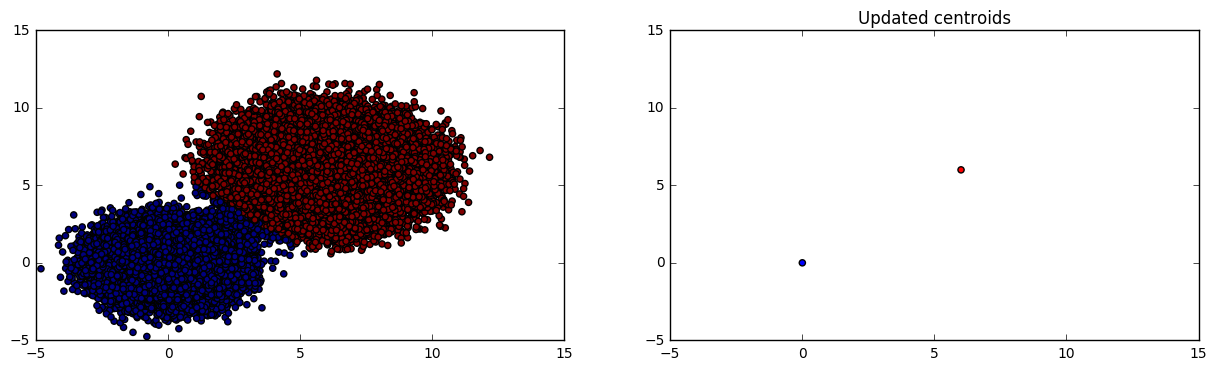

In [223]:
n_points = 100000
n_clusters = 2
n_iter = 10

X = generate_mixture(n_points)

start = timer()
cluster, centers = kmeans(n_clusters, X, n_iter)
dt = timer() - start
print("Kmeans with %.0f points and %.0f clusters with %.0f iterations on CPU in %f s" % (n_points, n_clusters, n_iter, dt))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c = cluster)
plt.xlim([-5, 15])
plt.ylim([-5, 15])

plt.subplot(1, 2, 2)
plt.title('Updated centroids')
plt.scatter(centers[:, 0], centers[:, 1], c = 'br')
plt.xlim([-5, 15])
plt.ylim([-5, 15])


### Test with numba

In [155]:
from numba import cuda, vectorize, guvectorize
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
import numba

In [220]:
@numba.jit
def dist_numba(x1, x2):
    return np.sqrt(sum((x1-x2)**2))

@numba.jit
def kmeans_numba(k, X, n_iter=100):
    # Initialize from random points.
    centers = [X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]
    cluster = [None] * np.shape(X)[0]
 
    for _ in range(n_iter):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: dist_numba(X[i], centers[j]))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            centers[j] = np.mean(members) #update the centers from the elements of each cluster
    return cluster


In [221]:
n_clusters = 2
n_iter = 5

start = timer()
my_cluster = kmeans_numba(n_clusters, X, n_iter)
dt = timer() - start
print("Kmeans with %.0f points and %.0f clusters with %.0f iterations on CPU with Numba in %f s" % (n_points, n_clusters, n_iter, dt))


plt.scatter(X[:, 0], X[:, 1], c = my_cluster)

AttributeError: Failed at object (analyzing bytecode)
'DataFlowAnalysis' object has no attribute 'op_LOAD_CLOSURE'

### Test with Cuda

## Parallel Kmeans